In [10]:
from sklearn.datasets import load_sample_image

china = load_sample_image('china.jpg')

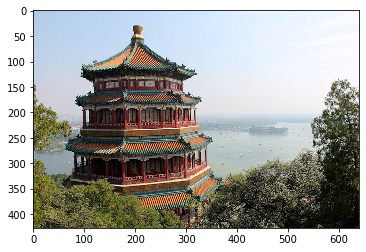

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(china)

In [12]:
china = china/255.0

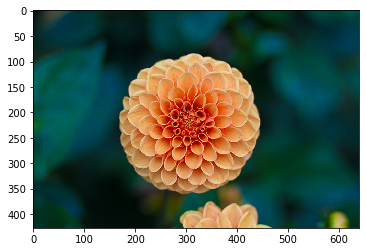

In [14]:
flower = load_sample_image('flower.jpg')
plt.imshow(flower)

In [15]:
flower = flower / 255.0

In [19]:
import numpy as np
images = np.array([china, flower])
images.shape

(2, 427, 640, 3)

In [18]:
batch_size, height, width, channels = images.shape

In [27]:
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
print(filters.shape)
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1

(7, 7, 3, 2)


In [23]:
import tensorflow as tf
outputs = tf.nn.conv2d(images, filters, strides=1, padding='SAME')

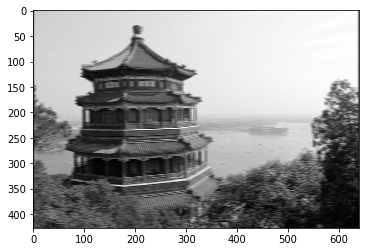

In [26]:
plt.imshow(outputs[0,:,:,1], cmap='gray')
plt.show()

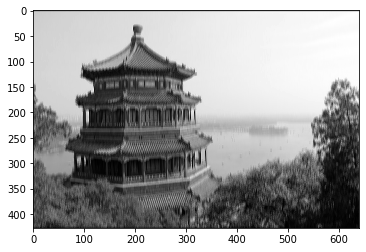

In [31]:
plt.imshow(outputs[0,:,:,0], cmap='gray')
plt.show()

In [32]:
outputs_VALID = tf.nn.conv2d(images, filters, strides=1, padding='VALID')

In [34]:
print(outputs.shape)
print(outputs_VALID.shape)

(2, 427, 640, 2)
(2, 421, 634, 2)


In [35]:
from tensorflow import keras
conv = keras.layers.Conv2D(filters=32, kernel_size = 3, strides = 1,
                          padding='same', activation = 'relu')

In [36]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [40]:
output = tf.nn.max_pool(images,
                      ksize=(1, 1, 1, 3),
                      strides=(1,1,1,3),
                      padding = 'VALID')

In [45]:
output.shape

TensorShape([2, 427, 640, 1])

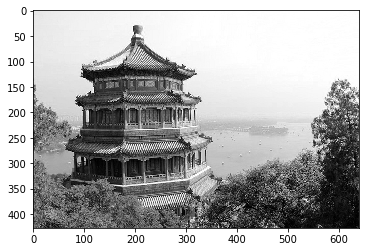

In [50]:
plt.imshow(output[0,:,:,0],cmap='gray')

In [51]:
depth_pool = keras.layers.Lambda(
    lambda x : tf.nn.max_pool(X, ksize=(1, 1, 1, 3), strides = (1, 1, 1, 3), padding='valid')
)

In [52]:
global_avg_pool = keras.layers.GlobalAvgPool2D()

In [53]:
global_avg_pool = keras.layers.Lambda(lambda X : tf.reduce_mean(X, axis=[1, 2]))

In [54]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation='relu', padding='same', input_shape=[28, 28, 1]),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPool2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(.5),
    keras.layers.Dense(10, activation='softmax')
])

In [72]:
mnist_data = keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist_data.load_data()


In [74]:
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

In [76]:
print(X_train.shape)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
print(X_train.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


In [75]:
X_train.shape

(60000, 28, 28)

In [64]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='nadam',
             metrics=['accuracy'])

In [58]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('mnist_cnn_checkpoint.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [62]:
import os
root_logdir = os.path.join(os.curdir, 'my_logs')
if not os.path.exists(root_logdir):
    os.mkdir(root_logdir)

def get_run_logdir(file_name):
    import time
    run_id = time.strftime('run_%Y_%m_%d_%H_%M_%S_{}'.format(file_name))
    return os.path.join(root_logdir, run_id)

run_log_dir = get_run_logdir('cnn_mnist')

In [77]:
tensorboard_cb = keras.callbacks.TensorBoard(run_log_dir)
history = model.fit(X_train, y_train, epochs=100, 
                   validation_split=.2,
                   callbacks=[checkpoint_cb, earlystopping_cb, tensorboard_cb])

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 172s 4ms/sample - loss: 0.4112 - accuracy: 0.8784 - val_loss: 0.1013 - val_accuracy: 0.9744
Epoch 2/100
48000/48000 [==============================] - 171s 4ms/sample - loss: 0.1164 - accuracy: 0.9728 - val_loss: 0.0675 - val_accuracy: 0.9844
Epoch 3/100
48000/48000 [==============================] - 173s 4ms/sample - loss: 0.0920 - accuracy: 0.9786 - val_loss: 0.0640 - val_accuracy: 0.9842
Epoch 4/100
48000/48000 [==============================] - 175s 4ms/sample - loss: 0.0787 - accuracy: 0.9822 - val_loss: 0.0561 - val_accuracy: 0.9875
Epoch 5/100
48000/48000 [==============================] - 175s 4ms/sample - loss: 0.0721 - accuracy: 0.9840 - val_loss: 0.0501 - val_accuracy: 0.9893
Epoch 6/100
48000/48000 [==============================] - 175s 4ms/sample - loss: 0.0585 - accuracy: 0.9864 - val_loss: 0.0631 - val_accuracy: 0.9852
Epoch 7/100
48000/48000 [===================

In [78]:
model.evaluate(X_test,y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[681.7056062339125, 0.99]

In [79]:
y_pred = model.predict(X_test)

In [83]:
y_pred = y_pred.argmax(axis=1)

In [84]:
y_pred

array([7, 2, 1, ..., 4, 5, 6])

In [80]:
from sklearn.metrics import confusion_matrix

In [85]:
confusion_matrix(y_test, y_pred)

array([[ 974,    0,    1,    0,    0,    1,    1,    3,    0,    0],
       [   0, 1124,    2,    2,    0,    3,    0,    2,    2,    0],
       [   0,    0, 1027,    0,    0,    0,    1,    4,    0,    0],
       [   0,    0,    0, 1000,    0,    8,    0,    2,    0,    0],
       [   1,    1,    0,    0,  963,    0,    9,    1,    0,    7],
       [   0,    0,    0,    1,    0,  891,    0,    0,    0,    0],
       [   3,    4,    0,    0,    0,    2,  948,    0,    1,    0],
       [   0,    2,    6,    0,    1,    2,    0, 1015,    0,    2],
       [   1,    1,    0,    2,    0,    0,    1,    0,  964,    5],
       [   2,    0,    2,    1,    3,    4,    0,    3,    0,  994]])

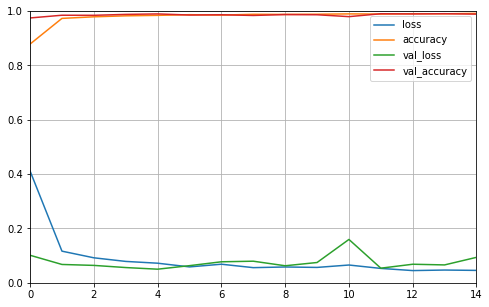

In [88]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


# LeNet-5

In [114]:
mnist_data = keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist_data.load_data()
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std
X_train_padding = np.pad(X_train, pad_width=((0,0),(2,2),(2,2)), mode='constant', constant_values = 0)
X_test_padding = np.pad(X_test, pad_width=((0,0),(2,2),(2,2)), mode='constant', constant_values = 0)

In [115]:
X_train_padding.shape

(60000, 32, 32)

In [116]:
X_train.shape

(60000, 28, 28)

In [117]:
print(X_train_padding.shape)
X_train_padding = X_train_padding[..., np.newaxis]
X_test = X_test[..., np.newaxis]
print(X_train_padding.shape)

(60000, 32, 32)
(60000, 32, 32, 1)


In [135]:
X_test_padding = X_test_padding[..., np.newaxis]
X_test_padding.shape

(10000, 32, 32, 1)

In [121]:
from keras.layers import Layer
from keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff,2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

Using TensorFlow backend.


In [127]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(32,32,1), name='Input'),
    keras.layers.Conv2D(6, kernel_size=(5,5), strides=1, activation='tanh', name='C1'),
    keras.layers.AvgPool2D(pool_size=(2,2), strides=2, name='S2'),
    keras.layers.Conv2D(16, kernel_size=(5,5), strides=1, activation='tanh', name='C3'),
    keras.layers.AvgPool2D(pool_size=(2,2), strides=2, name='S4'),
    keras.layers.Conv2D(120, kernel_size=(5, 5), strides=1, activation='tanh', name = 'C5'),
    keras.layers.Flatten(),
    keras.layers.Dense(84, activation='tanh', name='F6'),
    keras.layers.Dense(10, activation=RBFLayer(10, 0.5), name='Output')
])

In [128]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='nadam',
             metrics=['accuracy'])

In [129]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('mnist_le_net_5_checkpoint.h5', save_best_only=True)
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [130]:
run_log_dir = get_run_logdir('le_net_5_mnist')

In [132]:
tensorboard_cb = keras.callbacks.TensorBoard(run_log_dir)
history = model.fit(X_train_padding, y_train, epochs=100, 
                   validation_split=.2,
                   callbacks=[checkpoint_cb, earlystopping_cb, tensorboard_cb])

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 16s 330us/sample - loss: 2.0019 - accuracy: 0.7792 - val_loss: 1.9364 - val_accuracy: 0.8853
Epoch 2/100
48000/48000 [==============================] - 15s 323us/sample - loss: 1.9235 - accuracy: 0.9142 - val_loss: 1.9074 - val_accuracy: 0.9394
Epoch 3/100
48000/48000 [==============================] - 14s 301us/sample - loss: 1.9010 - accuracy: 0.9508 - val_loss: 1.8931 - val_accuracy: 0.9566
Epoch 4/100
48000/48000 [==============================] - 15s 310us/sample - loss: 1.8919 - accuracy: 0.9618 - val_loss: 1.8883 - val_accuracy: 0.9635
Epoch 5/100
48000/48000 [==============================] - 15s 312us/sample - loss: 1.8878 - accuracy: 0.9659 - val_loss: 1.8870 - val_accuracy: 0.9713
Epoch 6/100
48000/48000 [==============================] - 16s 330us/sample - loss: 1.8848 - accuracy: 0.9736 - val_loss: 1.8859 - val_accuracy: 0.9728
Epoch 7/100
48000/48000 [=============

In [136]:
model.evaluate(X_test_padding, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.8722885959625244, 0.9871]

In [137]:
y_pred = model.predict_classes(X_test_padding)

In [138]:
y_pred

array([7, 2, 1, ..., 4, 5, 6])

In [139]:
confusion_matrix(y_test, y_pred)

array([[ 977,    0,    0,    0,    0,    1,    1,    1,    0,    0],
       [   0, 1117,    0,    3,    4,    0,    3,    0,    2,    6],
       [   1,    0, 1024,    1,    1,    0,    0,    5,    0,    0],
       [   0,    1,    0, 1003,    0,    2,    0,    1,    1,    2],
       [   0,    0,    1,    0,  971,    0,    3,    0,    0,    7],
       [   2,    0,    0,    7,    0,  878,    1,    1,    1,    2],
       [   3,    1,    0,    1,    2,    3,  945,    1,    2,    0],
       [   0,    1,    4,    3,    1,    0,    0, 1017,    0,    2],
       [   3,    0,    4,    5,    0,    3,    0,    3,  954,    2],
       [   0,    0,    1,    0,   11,    3,    0,    8,    1,  985]])